In [1]:
%bash
bq mk demos
bq rm -f demos.coastline_images
bq load \
   --source_format=CSV --skip_leading_rows=1 \
   demos.coastline_images \
   gs://tamucc_coastline/labeled_images.csv \
   image_url:string,short_label:string,label:string

BigQuery error in mk operation: Dataset 'emirates-ga-cloud-staging:demos'
already exists.



Waiting on bqjob_r4de4ed0f7fdd7b81_00000165a5b493dd_1 ... (0s) Current status: DONE   

/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


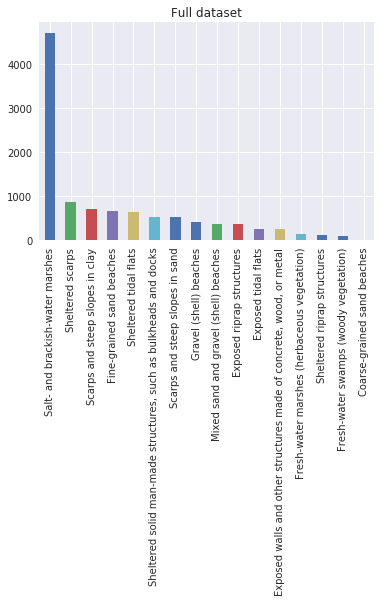

In [2]:
import matplotlib.pyplot as plt
import google.datalab.bigquery as bq
df = bq.Query("SELECT image_url, label FROM demos.coastline_images").execute().result().to_dataframe()
df['label'].value_counts().plot(kind='bar', title='Full dataset');

In [3]:
%bash
QUERY='SELECT image_url, label FROM '
TABLE="${PROJECT_ID}.demos.coastline_images"
SUBSAMPLE='WHERE (short_label = "2A" OR short_label = "3A" OR short_label = "9") AND MOD(ABS(FARM_FINGERPRINT(image_url)), 10) = 0'
bq rm -f demos.coastline_train
bq query --use_legacy_sql=false  --destination_table=demos.coastline_train "$QUERY \`$TABLE\` $SUBSAMPLE"


+----------------------------------------------------------------+---------------------------+
|                           image_url                            |           label           |
+----------------------------------------------------------------+---------------------------+
| gs://tamucc_coastline/esi_images/IMG_0908_SecBC_Spr12.jpg      | Sheltered tidal flats     |
| gs://tamucc_coastline/esi_images/IMG_4534_SecFG_Spr12.jpg      | Sheltered tidal flats     |
| gs://tamucc_coastline/esi_images/IMG_4048_SecABD_Sum12_Pt1.jpg | Sheltered tidal flats     |
| gs://tamucc_coastline/esi_images/IMG_7762_SecG_Spr12.jpg       | Sheltered tidal flats     |
| gs://tamucc_coastline/esi_images/IMG_2424_SecDE_Spr12.jpg      | Sheltered tidal flats     |
| gs://tamucc_coastline/esi_images/IMG_2070_SecDE_Spr12.jpg      | Sheltered tidal flats     |
| gs://tamucc_coastline/esi_images/IMG_7364_SecG_Spr12.jpg       | Sheltered tidal flats     |
| gs://tamucc_coastline/esi_images/IMG_8468_SecG_

Waiting on bqjob_r3b52b610c0416d99_00000165a4faf197_1 ... (0s) Current status: DONE   

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


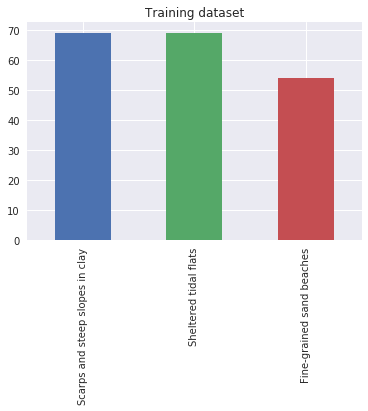

In [2]:
import matplotlib.pyplot as plt
import google.datalab.bigquery as bq
train_df = bq.Query("SELECT image_url, label FROM demos.coastline_train").execute().result().to_dataframe()
train_df['label'].value_counts().plot(kind='bar', title='Training dataset');

In [3]:
bucket = 'gs://' + datalab_project_id() + '-txf'
preprocessed_dir = bucket + '/preprocessed'
model_dir = bucket + '/model'

In [6]:
import  subprocess
#print 'Creating bucket named {}'.format(bucket)
subprocess.check_call('gsutil mb {}'.format(bucket).split());

CalledProcessError: Command '['gsutil', 'mb', 'gs://emirates-ga-cloud-staging-txf']' returned non-zero exit status 1

In [ ]:
import mltoolbox.image.classification as model
from google.datalab.ml import *
import os

train_set = BigQueryDataSet("SELECT image_url, label FROM demos.coastline_train")
job = model.preprocess_async(train_set, preprocessed_dir, cloud={'num_workers': 4})